In [ ]:
# 05 - Segmentation UNET
# Algorithme de deep learning de type UNET avec pour cible le masque BDTOPO

# Caractéristiques :
#    - Zoom et scaling dans la génération
#    - ImageDataGenerator pour les données de train, validation et de test
#    - Profondeur jusqu'à 512
#    - Batch normalisations à chaque étape d'expansion (cf. site Keras UNET)
#    - Pas de Droupout
#    - Ajout d'une couche plus profonde
#    - Utilisation de la BinaryCrossEntropy,  adaptée à la classification binaire

In [230]:
# Définitions globales
HOME = '/Users/u600141/OneDrive - La Francaise des Jeux/Data/constructions/'

# Si RGB
PATHS_BDORTHO_PICKLE = HOME + 'images/BDORTHO_RGB/pickle/'
# Si IRC
#PATHS_BDORTHO_PICKLE = HOME + 'images/BDORTHO_IRC/pickle/'

IMAGE_SIZE = (512, 512)
BATCH_SIZE = 16
SEED = 123
COLOR_TP, COLOR_TN, COLOR_FP, COLOR_FN = '#FFFFFF', '#000000', '#FF0000', '#8080FF' # Couleurs pour "image-matrice de confusion"


In [2]:
# Imports standard
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2
import dr
from sklearn.metrics import classification_report


In [167]:
# Chargement des méta-données BDORTHO
dfi = pd.read_pickle(PATHS_BDORTHO_PICKLE + 'dfi.pkl')
print (f'dfi chargé, taille : {len(dfi)}')

dfi chargé, taille : 11875


In [4]:
# Imports Deep learning
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.saving import load_model
from keras.utils import to_categorical
from PIL import Image 
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers.legacy import Adam # car sinon lent sur M1
import os


In [168]:
# Séparation du jeu de données
# On garde 10% en validation finale (80% train et 20% test sur les 90% restant) 
df_test = dfi[(dfi.index % 10) == 0].reset_index()
df_train, df_valid = train_test_split(dfi[(dfi.index % 10) != 0], test_size=0.2, random_state=SEED)

print (f'Lignes df_train : {len(df_train)} ({len(df_train)/len(dfi)*100:.0f} %)')
print (f'Lignes df_valid : {len(df_valid)} ({len(df_valid)/len(dfi)*100:.0f} %)')
print (f'Lignes df_test  : {len(df_test)} ({len(df_test)/len(dfi)*100:.0f} %)')


Lignes df_train : 8549 (72 %)
Lignes df_valid : 2138 (18 %)
Lignes df_test  : 1188 (10 %)


In [75]:
# Définition des générateurs et flux

def preprocess_image(img):
    img = tf.cast(img, tf.float32) / 255.0
    return img

def preprocess_mask(mask):
    mask = tf.cast(mask / 255, tf.int32)
    return mask

# TRAIN
image_train_datagen = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=5,
                                    height_shift_range=5,
                                    fill_mode='nearest',
                                    preprocessing_function=preprocess_image)

mask_train_datagen = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=5,
                                    height_shift_range=5,
                                    fill_mode='nearest',
                                    preprocessing_function=preprocess_mask)

image_train_generator = image_train_datagen.flow_from_dataframe(dataframe=df_train,
                                                 x_col='filename',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 seed=SEED,
                                                 shuffle=True,
                                                 class_mode=None)

mask_train_generator = mask_train_datagen.flow_from_dataframe(dataframe=df_train,
                                                 x_col='mask_filename',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 seed=SEED,
                                                 shuffle=True,
                                                 class_mode=None,
                                                 color_mode='grayscale')

train_generator = zip(image_train_generator, mask_train_generator)

# VALID
image_valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
mask_valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_mask)

image_valid_generator = image_valid_datagen.flow_from_dataframe(dataframe=df_valid,
                                                 x_col='filename',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 seed=SEED,
                                                 shuffle=False,
                                                 class_mode=None)

mask_valid_generator = mask_valid_datagen.flow_from_dataframe(dataframe=df_valid,
                                                 x_col='mask_filename',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 seed=SEED,
                                                 class_mode=None,
                                                 shuffle=False,
                                                 color_mode='grayscale')

valid_generator = zip(image_valid_generator, mask_valid_generator)

# TEST
image_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
mask_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_mask)

image_test_generator = image_test_datagen.flow_from_dataframe(dataframe=df_test,
                                                 x_col='filename',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 seed=SEED,
                                                 shuffle=False,
                                                 class_mode=None)

mask_test_generator = mask_test_datagen.flow_from_dataframe(dataframe=df_test,
                                                 x_col='mask_filename',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 seed=SEED,
                                                 shuffle=False,
                                                 class_mode=None,
                                                 color_mode='grayscale')

test_generator = zip(image_test_generator, mask_test_generator)


Found 8549 validated image filenames.
Found 8549 validated image filenames.
Found 2138 validated image filenames.
Found 2138 validated image filenames.
Found 1188 validated image filenames.
Found 1188 validated image filenames.


2024-02-29 11:11:54.276509: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-29 11:11:54.276534: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-29 11:11:54.276538: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-29 11:11:54.276593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-29 11:11:54.276629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


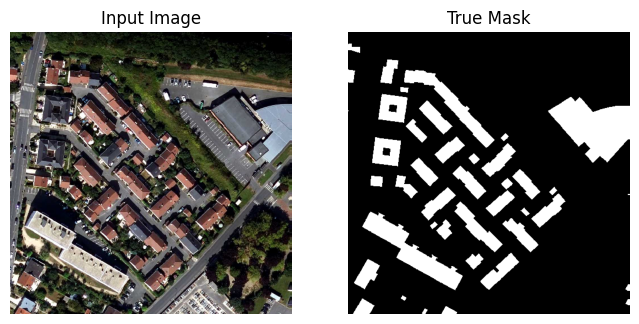

In [7]:
# Test du train_generator
import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list):
    plt.figure(figsize=(8, 8))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(display_list[i])
        else:
            plt.imshow(display_list[i]/2, cmap = "gray")
        plt.axis('off')
    plt.show()
    
### Insérez vote code
sample_image_batch, sample_mask_batch = next(iter(train_generator))
sample_image, sample_mask = sample_image_batch[0], sample_mask_batch[0]
display([sample_image, sample_mask])

In [15]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

model_checkpoint = ModelCheckpoint(
    filepath=dr.makeFileNameRoot('models/model UNET'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.01, patience=20, mode='min', verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         min_delta=0.01, patience=8, factor=0.1,
                                         cooldown=5, verbose=1)

time_callback = TimingCallback()


In [16]:
# Modèle de type UNET

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

NB_CLASS = 1

inputs = Input((IMAGE_SIZE[0],IMAGE_SIZE[1],3))

conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv1')(inputs)
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv1b')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)
batch1  = BatchNormalization()(pool1)

conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv2')(batch1)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv2b')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)
batch2 = BatchNormalization()(pool2)

conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv3')(batch2)
conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv3b')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)
batch3 = BatchNormalization()(pool3)

conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv4')(batch3)
conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv4b')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)
batch4 = BatchNormalization()(pool4)

conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv5')(batch4)
conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv5b')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2), name='pool5')(conv5)
batch5 = BatchNormalization()(pool5)

conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv6')(batch5)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv6b')(conv6)
pool6 = MaxPooling2D(pool_size=(2, 2), name='pool6')(conv6)
batch6 = BatchNormalization()(pool6)

up7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(batch6))
batch7 = BatchNormalization()(up7)
merge7 = concatenate([batch5, batch7], axis = 3)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
batch8 = BatchNormalization()(up8)
merge8 = concatenate([batch4, batch8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
batch9 = BatchNormalization()(up9)
merge9 = concatenate([batch3, batch9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

up10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
batch10 = BatchNormalization()(up10)
merge10 = concatenate([batch2, batch10], axis = 3)
conv10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
conv10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)

up11 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
batch11 = BatchNormalization()(up11)
merge11 = concatenate([batch1, batch11], axis = 3)
conv11 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11)
conv11 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)

up12 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv11))
conv12 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up12)

outputs = Conv2D(NB_CLASS, 1, activation = 'sigmoid')(conv12)

model = Model(inputs=inputs, outputs=outputs)



Transfer learning en utilisant la même normalisation que le modèle d'origine
flow_from_dataset/dataframe
Appliquer un gradcam

Structure encodeur-décodeur (CNL en passant par des upsampling : principe du UNET)
Sauvegarder les images en UINT8 (ne pas normaliser avant de sauvegarder)
Resizing avant de stocker


In [17]:
# Métriques et Compilation du modèle

#model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 512, 512, 16)         448       ['input_2[0][0]']             
                                                                                                  
 conv1b (Conv2D)             (None, 512, 512, 16)         2320      ['conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 256, 256, 16)         0         ['conv1b[0][0]']              
                                                                                            

In [18]:
# Entraînement du modèle
model_history = model.fit(train_generator,
                                epochs=100,
                                steps_per_epoch=len(df_train) // (BATCH_SIZE),
                                callbacks=[model_checkpoint, early_stopping, reduce_learning_rate, time_callback],
                                validation_data=valid_generator,
                                validation_steps=len(df_valid) // (BATCH_SIZE),
                                verbose=True)


Epoch 1/100
534/534 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8720
Epoch 1: val_loss improved from inf to 0.26378, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 719s 1s/step - loss: 0.2920 - accuracy: 0.8720 - val_loss: 0.2638 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 2/100
534/534 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9040
Epoch 2: val_loss did not improve from 0.26378
534/534 [==============================] - 696s 1s/step - loss: 0.2322 - accuracy: 0.9040 - val_loss: 0.3853 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 3/100
534/534 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9104
Epoch 3: val_loss improved from 0.26378 to 0.23931, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 692s 1s/step - loss: 0.2176 - accuracy: 0.9104 - val_loss: 0.2393 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 4/100
534/534 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.9139
Epoch 4: val_loss improved from 0.23931 to 0.19957, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 718s 1s/step - loss: 0.2109 - accuracy: 0.9139 - val_loss: 0.1996 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 5/100
534/534 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9152
Epoch 5: val_loss did not improve from 0.19957
534/534 [==============================] - 702s 1s/step - loss: 0.2053 - accuracy: 0.9152 - val_loss: 0.2151 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 6/100
534/534 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9085
Epoch 6: val_loss improved from 0.19957 to 0.19099, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 685s 1s/step - loss: 0.2128 - accuracy: 0.9085 - val_loss: 0.1910 - val_accuracy: 0.9224 - lr: 0.0010
Epoch 7/100
534/534 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9102
Epoch 7: val_loss improved from 0.19099 to 0.18732, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 656s 1s/step - loss: 0.2178 - accuracy: 0.9102 - val_loss: 0.1873 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 8/100
534/534 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9121
Epoch 8: val_loss did not improve from 0.18732
534/534 [==============================] - 649s 1s/step - loss: 0.2149 - accuracy: 0.9121 - val_loss: 0.1905 - val_accuracy: 0.9224 - lr: 0.0010
Epoch 9/100
534/534 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9105
Epoch 9: val_loss improved from 0.18732 to 0.18317, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 658s 1s/step - loss: 0.2171 - accuracy: 0.9105 - val_loss: 0.1832 - val_accuracy: 0.9251 - lr: 0.0010
Epoch 10/100
534/534 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9116
Epoch 10: val_loss improved from 0.18317 to 0.17860, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 657s 1s/step - loss: 0.2187 - accuracy: 0.9116 - val_loss: 0.1786 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 11/100
534/534 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9134
Epoch 11: val_loss did not improve from 0.17860
534/534 [==============================] - 673s 1s/step - loss: 0.2134 - accuracy: 0.9134 - val_loss: 0.2205 - val_accuracy: 0.9061 - lr: 0.0010
Epoch 12/100
534/534 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9107
Epoch 12: val_loss did not improve from 0.17860
534/534 [==============================] - 658s 1s/step - loss: 0.2157 - accuracy: 0.9107 - val_loss: 0.1804 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 13/100
534/534 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9153
Epoch 13: val_loss did not improve from 0.17860
534/534 [==============================] - 652s 1s/step - loss: 0.2056 - accuracy: 0.9153 - val_loss: 0.2003 - val_accuracy: 0.

INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 658s 1s/step - loss: 0.2040 - accuracy: 0.9178 - val_loss: 0.1621 - val_accuracy: 0.9342 - lr: 1.0000e-04
Epoch 17/100
534/534 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9199
Epoch 17: val_loss did not improve from 0.16208
534/534 [==============================] - 649s 1s/step - loss: 0.2028 - accuracy: 0.9199 - val_loss: 0.1626 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 18/100
534/534 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9191
Epoch 18: val_loss improved from 0.16208 to 0.16167, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 657s 1s/step - loss: 0.2045 - accuracy: 0.9191 - val_loss: 0.1617 - val_accuracy: 0.9345 - lr: 1.0000e-04
Epoch 19/100
534/534 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9190
Epoch 19: val_loss did not improve from 0.16167
534/534 [==============================] - 648s 1s/step - loss: 0.2037 - accuracy: 0.9190 - val_loss: 0.1623 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 20/100
534/534 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9216
Epoch 20: val_loss improved from 0.16167 to 0.16119, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 657s 1s/step - loss: 0.1988 - accuracy: 0.9216 - val_loss: 0.1612 - val_accuracy: 0.9348 - lr: 1.0000e-04
Epoch 21/100
534/534 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9199
Epoch 21: val_loss improved from 0.16119 to 0.16047, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 655s 1s/step - loss: 0.2020 - accuracy: 0.9199 - val_loss: 0.1605 - val_accuracy: 0.9352 - lr: 1.0000e-04
Epoch 22/100
534/534 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9199
Epoch 22: val_loss did not improve from 0.16047
534/534 [==============================] - 649s 1s/step - loss: 0.2023 - accuracy: 0.9199 - val_loss: 0.1609 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 23/100
534/534 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9222
Epoch 23: val_loss did not improve from 0.16047
534/534 [==============================] - 659s 1s/step - loss: 0.1969 - accuracy: 0.9222 - val_loss: 0.1613 - val_accuracy: 0.9352 - lr: 1.0000e-04
Epoch 24/100
534/534 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9199
Epoch 24: val_loss improved from 0.16047 to 0.15971, saving model to models/model UNET_202402282311
INFO:tensorflow:Assets written to: models/model UNET_2024022823

INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 696s 1s/step - loss: 0.2022 - accuracy: 0.9199 - val_loss: 0.1597 - val_accuracy: 0.9354 - lr: 1.0000e-04
Epoch 25/100
534/534 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9159
Epoch 25: val_loss did not improve from 0.15971
534/534 [==============================] - 641s 1s/step - loss: 0.2100 - accuracy: 0.9159 - val_loss: 0.1602 - val_accuracy: 0.9353 - lr: 1.0000e-04
Epoch 26/100
534/534 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9223
Epoch 26: val_loss did not improve from 0.15971
534/534 [==============================] - 651s 1s/step - loss: 0.1965 - accuracy: 0.9223 - val_loss: 0.1600 - val_accuracy: 0.9354 - lr: 1.0000e-04
Epoch 27/100
534/534 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9216
Epoch 27: val_loss did not improve from 0.15971

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
534/534 [===========================

INFO:tensorflow:Assets written to: models/model UNET_202402282311/assets


534/534 [==============================] - 656s 1s/step - loss: 0.2077 - accuracy: 0.9226 - val_loss: 0.1595 - val_accuracy: 0.9360 - lr: 1.0000e-05
Epoch 29/100
534/534 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9227
Epoch 29: val_loss did not improve from 0.15954
534/534 [==============================] - 651s 1s/step - loss: 0.2052 - accuracy: 0.9227 - val_loss: 0.1601 - val_accuracy: 0.9360 - lr: 1.0000e-05
Epoch 30/100
534/534 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9234
Epoch 30: val_loss did not improve from 0.15954
534/534 [==============================] - 651s 1s/step - loss: 0.2035 - accuracy: 0.9234 - val_loss: 0.1602 - val_accuracy: 0.9361 - lr: 1.0000e-05
Epoch 31/100
534/534 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9231
Epoch 31: val_loss did not improve from 0.15954
534/534 [==============================] - 652s 1s/step - loss: 0.2028 - accuracy: 0.9231 - val_loss: 0.1604 - val_

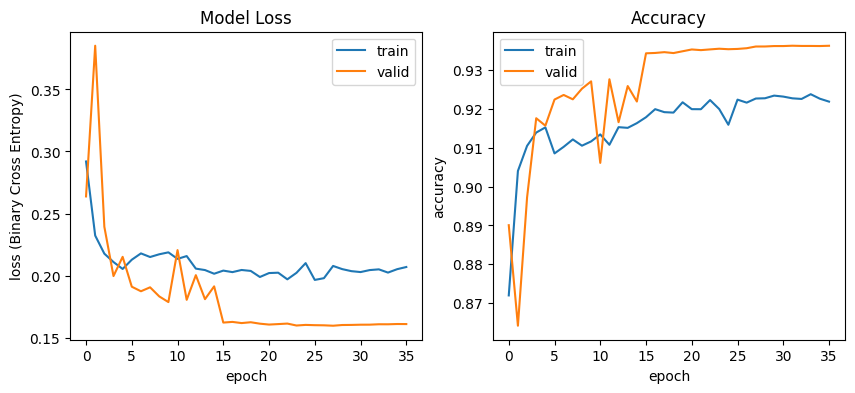

In [19]:
# Courbes d'évaluation de l'apprentissage 

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(figsize = (10, 4))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('loss (Binary Cross Entropy)')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')

plt.show()


In [8]:
# Chargement du modèle
model = load_model('models/model UNET_202402282311')

In [20]:
# Calcul du pourcentage de pixels "bâtiment"

nbpixels, nbbatpixels = 0, 0
for f in df_test['mask_filename']:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    nbpixels += img.shape[0] * img.shape[1]
    nbbatpixels += np.count_nonzero(img)

pcbat = round(nbbatpixels / nbpixels, 4)
print ('Part de pixels "bâtiment" :', pcbat)
print ('Accuracy de base :', 1 - pcbat)

Part de pixels "bâtiment" : 0.1915
Accuracy de base : 0.8085


In [231]:
# get_predicted_values() transforme une valeur prédite en valeur 1 ou 0 en fonction d'un seuil
def get_predicted_values(x, threshold=0.5):
    ret = np.where(x > threshold, 1, 0)
    return ret

# get_predicted_mask() retourne le masque prédit à partir d'une image source
def get_predicted_mask(model, img):
    img = preprocess_image(cv2.resize(img, IMAGE_SIZE))
    predprob = model.predict(np.reshape(img, (1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    pred = (get_predicted_values(predprob))
    pred = np.reshape(pred, IMAGE_SIZE)
    return pred

# get_confusion_img() retourne la matrice de confusion d'une image (pixel par pixel) sous forme d'image colorée
# en entrée : les masques réel et prédit
# en sortie : une image indiquant les FP, FN, TP, TN avec chacun une couleur différente
def get_confusion_img(test, pred):
    test = test.astype(bool)
    pred = pred.astype(bool)
    tp = (test & pred)
    tn = ((~test) & (~pred))
    fp = ((~test) & pred)
    fn = (test & (~pred))

    ret = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    ret[..., 0] += np.where(tp, int(COLOR_TP[1:3], 16), 0)
    ret[..., 1] += np.where(tp, int(COLOR_TP[3:5], 16), 0)
    ret[..., 2] += np.where(tp, int(COLOR_TP[5:7], 16), 0)

    ret[..., 0] += np.where(tn, int(COLOR_TN[1:3], 16), 0)
    ret[..., 1] += np.where(tn, int(COLOR_TN[3:5], 16), 0)
    ret[..., 2] += np.where(tn, int(COLOR_TN[5:7], 16), 0)

    ret[..., 0] += np.where(fp, int(COLOR_FP[1:3], 16), 0)
    ret[..., 1] += np.where(fp, int(COLOR_FP[3:5], 16), 0)
    ret[..., 2] += np.where(fp, int(COLOR_FP[5:7], 16), 0)

    ret[..., 0] += np.where(fn, int(COLOR_FN[1:3], 16), 0)
    ret[..., 1] += np.where(fn, int(COLOR_FN[3:5], 16), 0)
    ret[..., 2] += np.where(fn, int(COLOR_FN[5:7], 16), 0)

    return ret.astype(int)

1/1 [==============================] - 0s 59ms/step


/var/folders/rp/v2y1mh854lg1zw0c5hxqdks80000gp/T/ipykernel_4280/1255204127.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


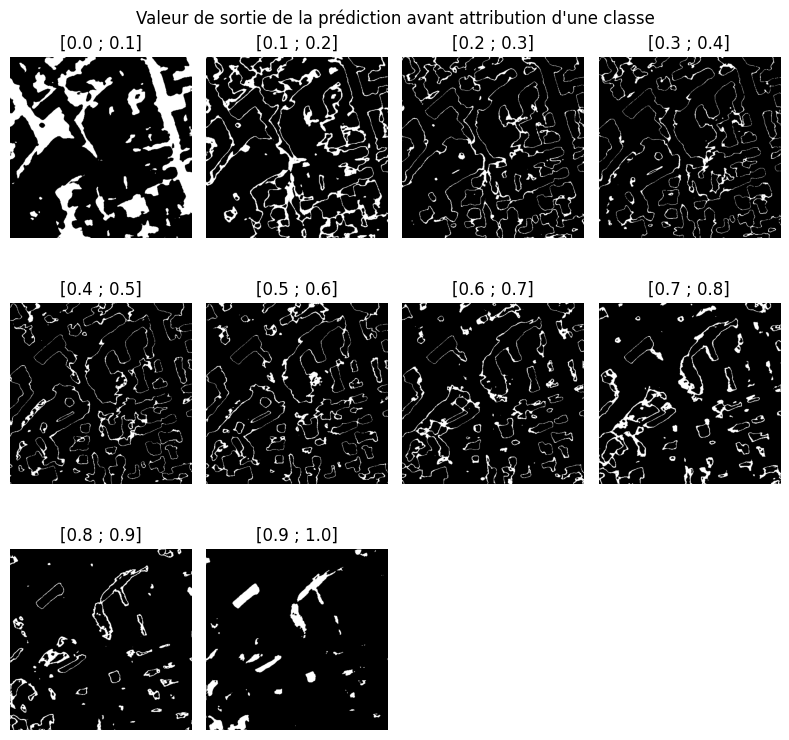

In [307]:
# Affichage des images de la valeur prédite par décile

f = HOME + 'images/BDORTHO_RGB/1000x1000/00-020.jpg'
img = cv2.imread(f)
img = preprocess_image(cv2.resize(img, IMAGE_SIZE))
predprob = model.predict(np.reshape(img, (1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
pred = (get_predicted_values(predprob))
predprob = np.reshape(predprob, IMAGE_SIZE)
pred = np.reshape(pred, IMAGE_SIZE)

fig = plt.figure(figsize=(8, 8))

# Affichage de la variable prédite par décile
for i in range(10):
    ax = fig.add_subplot(3, 4, i+1)
    mini, maxi = i / 10, (i+1) / 10
    x = (predprob >= mini) & (predprob <= maxi) * 255
    x = np.reshape(x, IMAGE_SIZE)
    plt.imshow(x, cmap='gray')
    plt.title(f'[{str(mini)} ; {str(maxi)}]')
    plt.axis('off')
    fig.tight_layout()
plt.suptitle('Valeur de sortie de la prédiction avant attribution d\'une classe')

plt.show();

1/1 [==============================] - 0s 59ms/step
              precision    recall  f1-score   support

         0.0       0.79      0.63      0.70    104472
         1.0       0.78      0.89      0.83    157672

    accuracy                           0.79    262144
   macro avg       0.79      0.76      0.77    262144
weighted avg       0.79      0.79      0.78    262144



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: 

KeyboardInterrupt: 

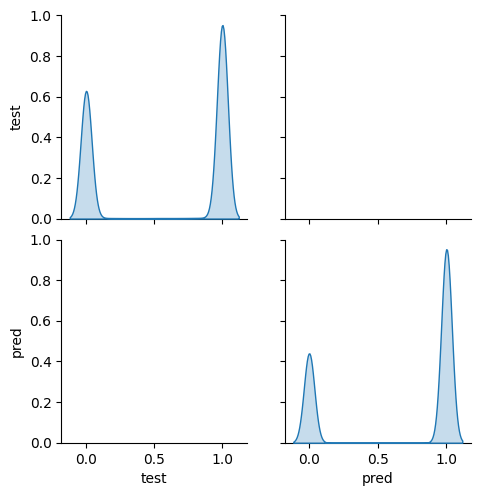

In [337]:
# Affichage de pairplot (réel, prédit) et de la matrice de confusion sur une image d'exemple
# Ici, on prend un seuil de 0.5

# Lecture de l'image et prédiction
f = HOME + 'images/BDORTHO_RGB/1000x1000/04-148.jpg'
img = cv2.imread(f)
img = preprocess_image(cv2.resize(img, IMAGE_SIZE))
predprob = model.predict(np.reshape(img, (1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
pred = (get_predicted_values(predprob))
pred = np.reshape(pred, IMAGE_SIZE)

# Lecture du masque
f = HOME + 'images/BDORTHO_RGB/masks_1000x1000/mask-04-148.png'
test = cv2.imread(f)[..., 0] / 255
test = cv2.resize(test, IMAGE_SIZE)

df = pd.DataFrame({'test' : np.reshape(test, IMAGE_SIZE[0] * IMAGE_SIZE[1]),
                   'pred' : np.reshape(pred, IMAGE_SIZE[0] * IMAGE_SIZE[1])})


t = test.reshape(test.shape[0] * test.shape[1])
t = np.round(t, 0)
p = pred.reshape(pred.shape[0] * pred.shape[1])
p = np.round(p, 0)
print (classification_report(t, p))

# Affichage de la pairplot
sns.pairplot(data=df, kind='kde')
plt.show();


In [ ]:
Les cellules suivantes servent à recalculer les métriques pour l'ensemble de la base.
On est obligés de redéfinir des fonctions pour calculer et afficher la matrice de confusion,
car la volumétrie est trop importante et on doit passer par des batches.

In [13]:
# calc_metrics() retourne precision, recall et f1-score pour un nombre d'observations données
# (tp, tn, fp et fn sont des nombres d'observations)
def calc_metrics(tp, tn, fp, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall) / (precision + recall)
    return precision, recall, f1_score

# print_metrics()
def print_metrics(tp, tn, fp, fn):
    print ('Confusion matrix')
    print ('------------------ PRED --------')
    print ('           Positive     Negative')
    print ('TRUE')
    print (f'Positive {tp}     {fn}')
    print (f'Negative {fp}     {tn}')
    print ('\n')

    precision_true, recall_true, f1_score_true = calc_metrics(tp, tn, fp, fn)
    precision_false, recall_false, f1_score_false = calc_metrics(tn, tp, fn, fp)

    print ('Classification report')
    print ('-------------- Bâtiments ----- Non bâtiments --------------')
    print (f'Precision :    {round(precision_true, 2)}           {round(precision_false, 2)}')
    print (f'Recall    :    {round(recall_true, 2)}           {round(recall_false, 2)}')
    print (f'f1-score  :    {round(f1_score_true, 2)}            {round(f1_score_false, 2)}')
    

In [312]:
# Calcul des indicateurs (pour tous les thresholds de 0.0 à 1.0)
# Retourne les TP, TN, FP et FN pour chaque pixel (sous forme de tableaux de dimension IMAGE_SIZE)

# calculateScoresAllThresholds() retourne 4 listes de 11 valeurs correspondant aux thresholds de 0.0 à 1.0
def calculateScoresAllThresholds():
    shp = (11, IMAGE_SIZE[0], IMAGE_SIZE[1])
    tp, tn, fp, fn = np.zeros(shp), np.zeros(shp), np.zeros(shp), np.zeros(shp)

    # Parcours de chaque batch
    for i in range(len(df_test) // BATCH_SIZE):
        imgs, masks = next(iter(test_generator))
        masks = masks.astype(bool).squeeze()
        preds = model.predict(imgs).squeeze()
        # calcul des indicateurs
        for i in range(11):
            threshold = i / 10
            predvals = get_predicted_values(preds, threshold).astype(bool)
            tp[i] += (masks & predvals).sum(axis=0)
            tn[i] += ((~masks) & (~predvals)).sum(axis=0)
            fp[i] += ((~masks) & predvals).sum(axis=0)
            fn[i] += (masks & (~predvals)).sum(axis=0)
    return tp, tn, fp, fn

tps_global, tns_global, fps_global, fns_global = calculateScoresAllThresholds()


1/1 [==============================] - 0s 224ms/step


/var/folders/rp/v2y1mh854lg1zw0c5hxqdks80000gp/T/ipykernel_4280/2794797381.py:4: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)


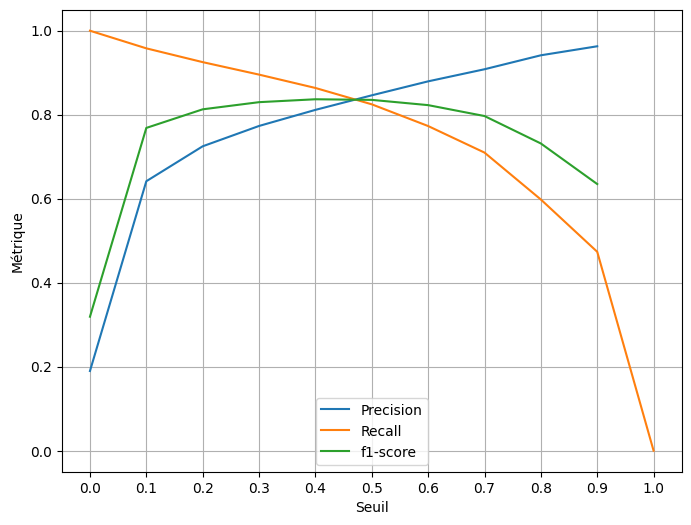

In [316]:
# Choix du meilleur threshold
precisions, recalls, f1_scores = calc_metrics(
    tps_global.sum(axis=(1, 2)), tns_global.sum(axis=(1, 2)), fps_global.sum(axis=(1, 2)), fns_global.sum(axis=(1, 2)))
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.plot(f1_scores, label='f1-score')
plt.legend(loc='lower center')
plt.xticks(list(np.arange(0, 11)), list(np.round(np.arange(0, 1.1, 0.1), 1)))
plt.xlabel('Seuil')
plt.ylabel('Métrique')
plt.grid()
plt.show();


In [317]:
# Métriques sur l'ensemble de validation, en prenant le meilleur threshold (par interpolation, 0.47)
THRESHOLD=0.47

# calculateScoresOneThreshold() retourne les TP, TN, FP et FN avec le seuil souhaité pour chaque pixel
# (sous forme de tableaux de dimension IMAGE_SIZE)
def calculateScoresOneThreshold(threshold):
    tp, tn, fp, fn = np.zeros(IMAGE_SIZE), np.zeros(IMAGE_SIZE), np.zeros(IMAGE_SIZE), np.zeros(IMAGE_SIZE)

    # Parcours de chaque batch
    for i in range(len(df_test) // BATCH_SIZE):
        imgs, masks = next(iter(test_generator))
        masks = masks.astype(bool).squeeze()
        preds = model.predict(imgs).squeeze()
        # calcul des indicateurs
        predvals = get_predicted_values(preds, threshold).astype(bool)
        tp += (masks & predvals).sum(axis=0)
        tn += ((~masks) & (~predvals)).sum(axis=0)
        fp += ((~masks) & predvals).sum(axis=0)
        fn += (masks & (~predvals)).sum(axis=0)

    return tp, tn, fp, fn

tp_global, tn_global, fp_global, fn_global = calculateScoresOneThreshold(THRESHOLD)


1/1 [==============================] - 0s 218ms/step


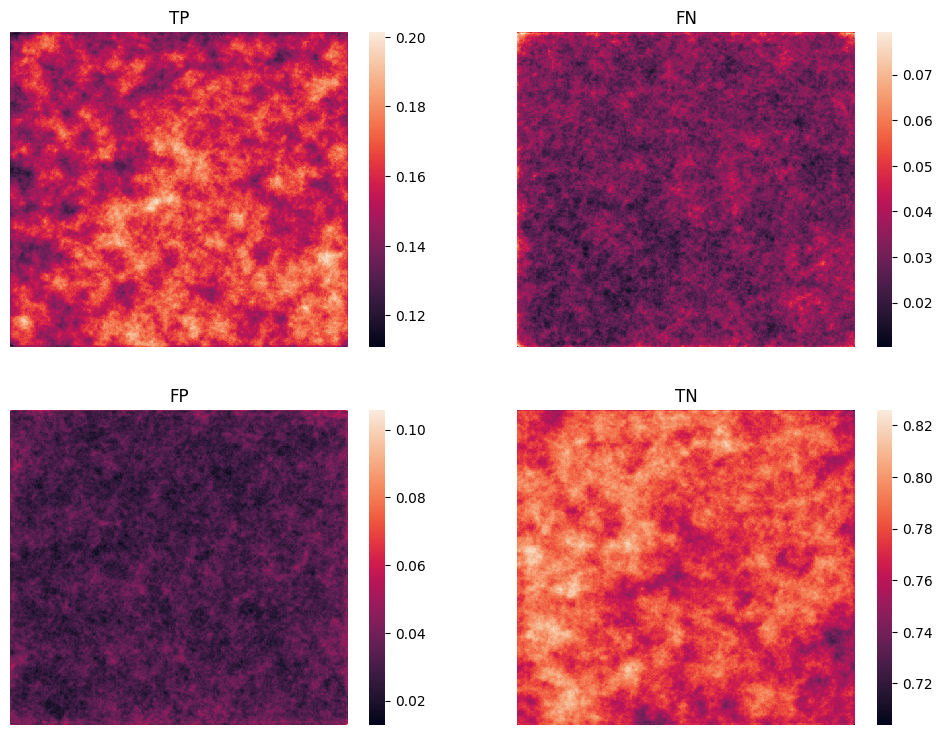

In [274]:
# Carte des tp, tn, fp, fn normalisés (afin de normaliser l'échelle)

nbimages = (tp_global + tn_global + fp_global + fn_global).sum() / (IMAGE_SIZE[0] * IMAGE_SIZE[1])
fig = plt.figure(figsize=(12, 9))

fig.add_subplot(221)
sns.heatmap(tp_global / nbimages)
plt.title('TP')
plt.axis('off')

fig.add_subplot(222)
sns.heatmap(fn_global / nbimages)
plt.title('FN')
plt.axis('off')

fig.add_subplot(223)
sns.heatmap(fp_global / nbimages)
plt.title('FP')
plt.axis('off')

fig.add_subplot(224)
sns.heatmap(tn_global / nbimages)
plt.title('TN')
plt.axis('off')

plt.show();

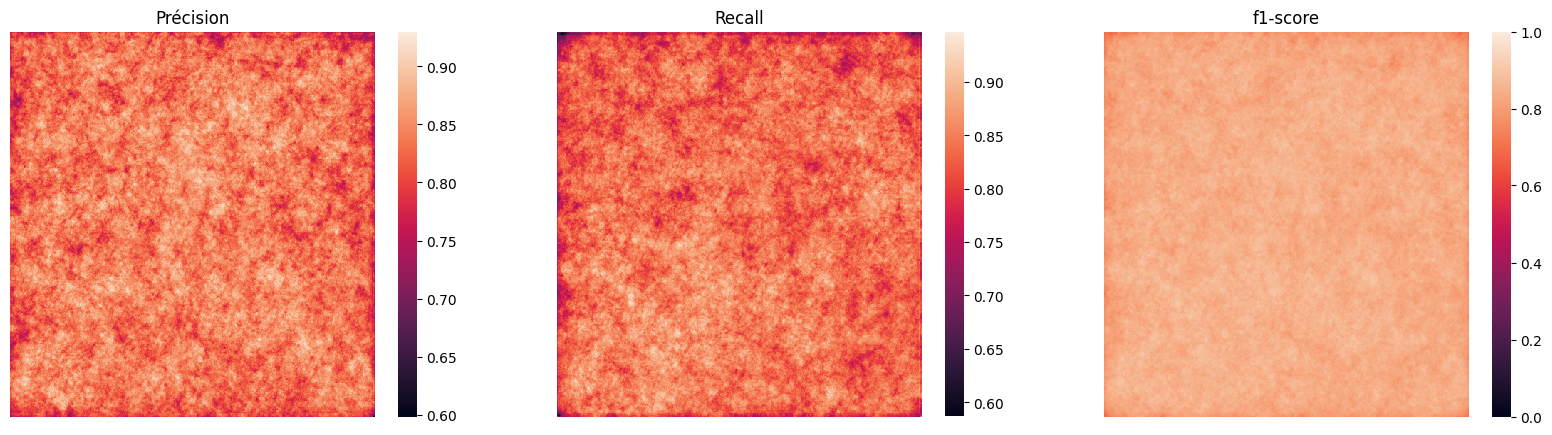

In [275]:
# Cartes des métriques
global_precision, global_recall, global_f1_score = calc_metrics(tp_global, tn_global, fp_global, fn_global)
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(131)
sns.heatmap(global_precision)
plt.title('Précision')
plt.axis('off')

fig.add_subplot(132)
sns.heatmap(global_recall)
plt.title('Recall')
plt.axis('off')

fig.add_subplot(133)
sns.heatmap(global_f1_score, vmin=0, vmax=1)
plt.title('f1-score')
plt.axis('off')

plt.show();

In [338]:

# Classe de base pour l'affichage des images, masques, prédictions, carte
# Sera dérivée selon le type de modèle (régression, classification)
# Cette classe gère essentiellement l'initialisation du dataframe des méta-données des images
# ainsi que l'affichage des cartes

class SimplePlotter():
    # La classe est créée avec un dataframe des méta-données des images
    # Le constructeur crée aussi le dataframe des rectangles représentant les grandes images BDTOPO
    def __init__(self, df_meta_images):
        self.dfi = df_meta_images
        self.dfrectangles = self.getOrthoImagesRectangles(dfi)

    # getOrthoImagesRectangles() retourne un dataframe des coordonnées des images non découpées
    def getOrthoImagesRectangles(self, dfi):
        dftmp = dfi.iloc[:,:4].copy()
        dftmp['xmin'] = dftmp['xrange'].apply(lambda v : v[0])
        dftmp['xmax'] = dftmp['xrange'].apply(lambda v : v[1])
        dftmp['ymin'] = dftmp['yrange'].apply(lambda v : v[0])
        dftmp['ymax'] = dftmp['yrange'].apply(lambda v : v[1])
        ret = dftmp.groupby(['imgID']).agg({'xmin' : 'min', 'xmax' : 'max', 'ymin' : 'min', 'ymax' : 'max'}).reset_index()
        ret['width'] = ret['xmax'] - ret['xmin']
        ret['height'] = ret['ymax'] - ret['ymin']
        return ret

    # plotImagesPositionsInRectangles() prend en entrée une liste de tuples (imgID, cutID)
    def plotImagesPositionsInRectangles(self, images, ax, indices=True):
        self.dfrectangles.apply(lambda r : ax.add_patch(Rectangle((r['xmin'], r['ymin']),
                                                                  r['width'], r['height'],
                                                                  edgecolor=(0.2, 0.2, 0.5, 1),
                                                                  facecolor=(0.9, 0.9, 0.9, 1), linewidth=2.0)),
                                                                  axis=1)
        if (indices):
            self.dfrectangles.apply(lambda r : ax.text(r['xmin'] + r['width'] / 2,
                                                       r['ymin'] + r['height'] / 2,
                                                       int(r['imgID']),
                                                       color='darkblue'),
                                                       axis=1)
        for img in images:
            img_metadata = self.dfi[(self.dfi['imgID']==img[0]) & (self.dfi['cutID']==img[1])]
            ax.add_patch(Rectangle((img_metadata['xrange'].values[0][0], img_metadata['yrange'].values[0][0]),
                    img_metadata['xrange'].values[0][1] - img_metadata['xrange'].values[0][0],
                    img_metadata['yrange'].values[0][1] - img_metadata['yrange'].values[0][0],
                    edgecolor=(1, 0, 0, 1),
                    facecolor=(1, 0, 0, 1),
                    linewidth=2.0))
        plt.xlim(self.dfrectangles['xmin'].min(), self.dfrectangles['xmax'].max())
        plt.ylim(self.dfrectangles['ymin'].min(), self.dfrectangles['ymax'].max())


# Classe permettant d'afficher les images pour un modèle de classification
# À ce stade, elle n'utilise pas l'affichage de la carte de la classe mère
class ClassificationPlotter(SimplePlotter):
    # La classe est créée avec un dataframe des méta-données des images
    # Attention : ce dataframe doit avoir un index à jour (après reset_index())
    def __init__(self, df_meta_images):
        super(ClassificationPlotter, self).__init__(df_meta_images)

    # plot() prend en entrée soit imgID et cutID, soit index
    def plot(self, imgID=None, cutID=None, index=None, model=None):
        if (index != None):
            img_metadata = self.dfi.iloc[index,:]
            ortho_filename = img_metadata['filename'].split(' ')[-1]
            topo_filename = img_metadata['mask_filename'].split(' ')[-1]
            imgID, cutID = img_metadata['imgID'], img_metadata['cutID']
        else:
            img_metadata = self.dfi[(self.dfi['imgID']==imgID) & (self.dfi['cutID']==cutID)]
            ortho_filename = img_metadata['filename'].values.item()
            topo_filename = img_metadata['mask_filename'].values.item()
            index = img_metadata.index
        fig = plt.figure(figsize=(10, 10))
        nblines = 1 if model == None else 2
        # Image ortho
        ax = fig.add_subplot(nblines, 2, 1)
        img = cv2.imread(ortho_filename)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        plt.imshow(img)
        plt.title('Image source')
        plt.axis('off')
        # Masque topo réel
        ax = fig.add_subplot(nblines, 2, 2)
        mask = cv2.imread(topo_filename)[...,0]
        mask = cv2.resize(mask, IMAGE_SIZE).astype('bool')
        plt.imshow(mask, cmap='gray')
        plt.title('Label')
        plt.axis('off')
        if (model == None):
            plt.suptitle(f'Image {imgID = }, {cutID = }')
        else:
            # Masque prédit
            ax = fig.add_subplot(nblines, 2, 3)
            predmask = get_predicted_mask(model, img).astype('bool')
            plt.imshow(predmask, cmap='gray')
            plt.title('Prédiction')
            plt.axis('off')
            # Différences entre prédit et réel
            ax = fig.add_subplot(nblines, 2, 4)
            plt.imshow(get_confusion_img(mask, predmask), norm='linear')
            plt.title('Diff (rouge=FP, bleu=FN)')
            plt.axis('off')
            # Affichage des scores
            tp = (mask & predmask).sum()
            tn = ((~mask) & (~predmask)).sum()
            fp = ((~mask) & predmask).sum()
            fn = (mask & (~predmask)).sum()
            print (tp, tn, fp, fn)
            precision, recall, f1_score = calc_metrics(tp, tn, fp, fn)
            plt.suptitle(f'Image {imgID = }, {cutID = }\n{precision=:.02}   {recall=:.02}   {f1_score=:.02}')
        plt.show();

plotter = ClassificationPlotter(df_test)


1/1 [==============================] - 0s 74ms/step
23868 227701 865 9710


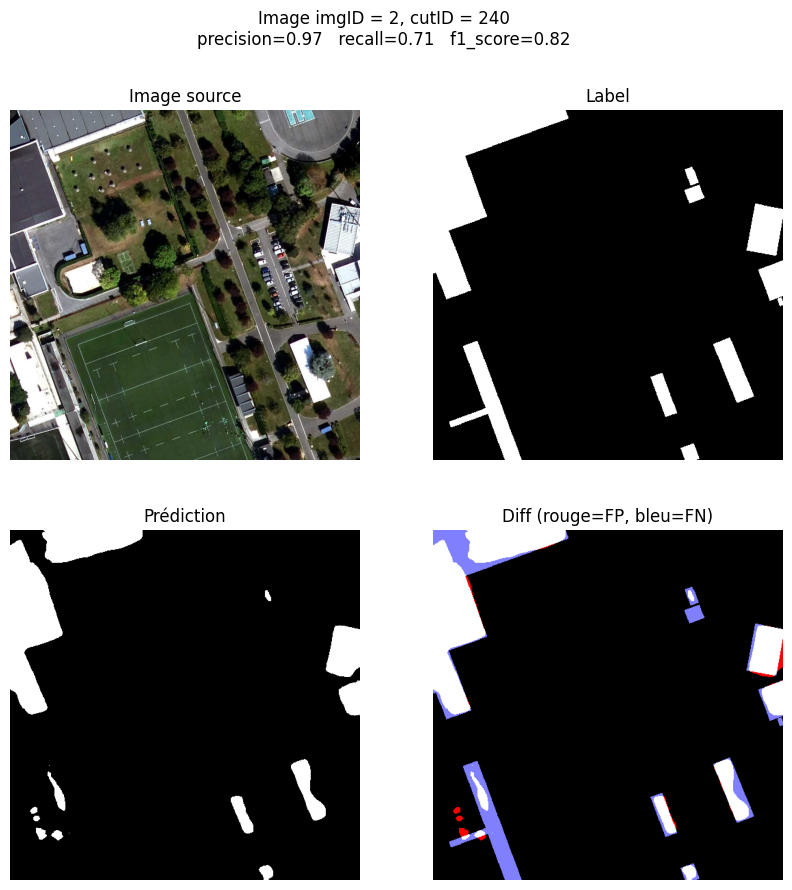

In [339]:
# Exemple d'image

imgID, cutID = 2, 240
plotter.plot(cutID=cutID, imgID=imgID, model=model)


1/1 [==============================] - 0s 60ms/step
89465 142765 13830 16084


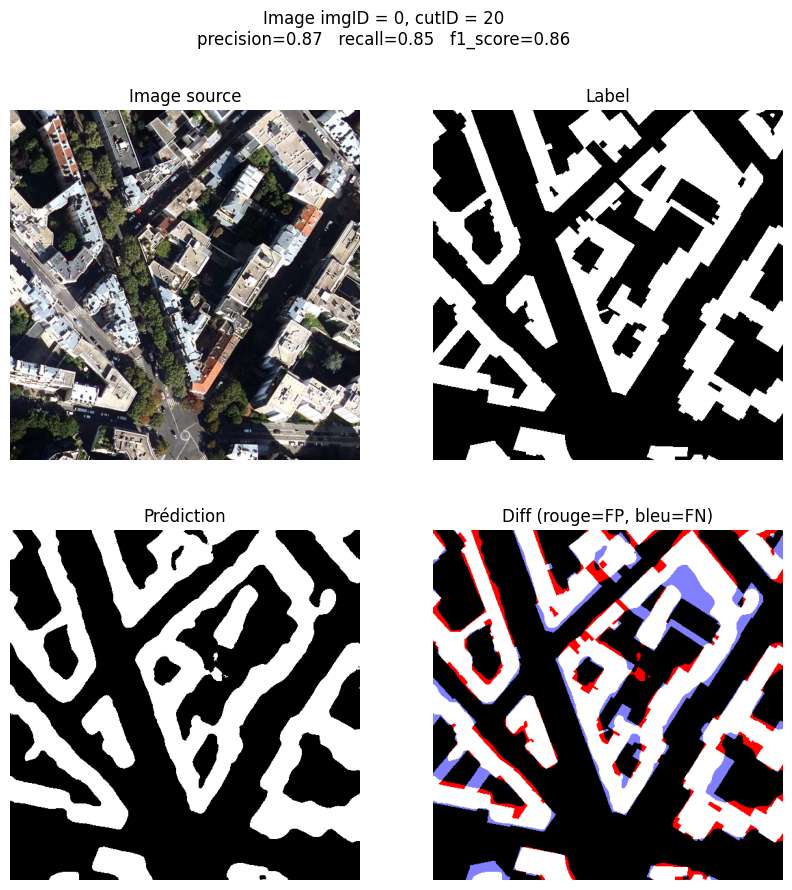

In [340]:
# Exemple d'image

imgID, cutID = 0, 20
plotter.plot(cutID=cutID, imgID=imgID, model=model)


1/1 [==============================] - 0s 59ms/step
62158 173139 10415 16432


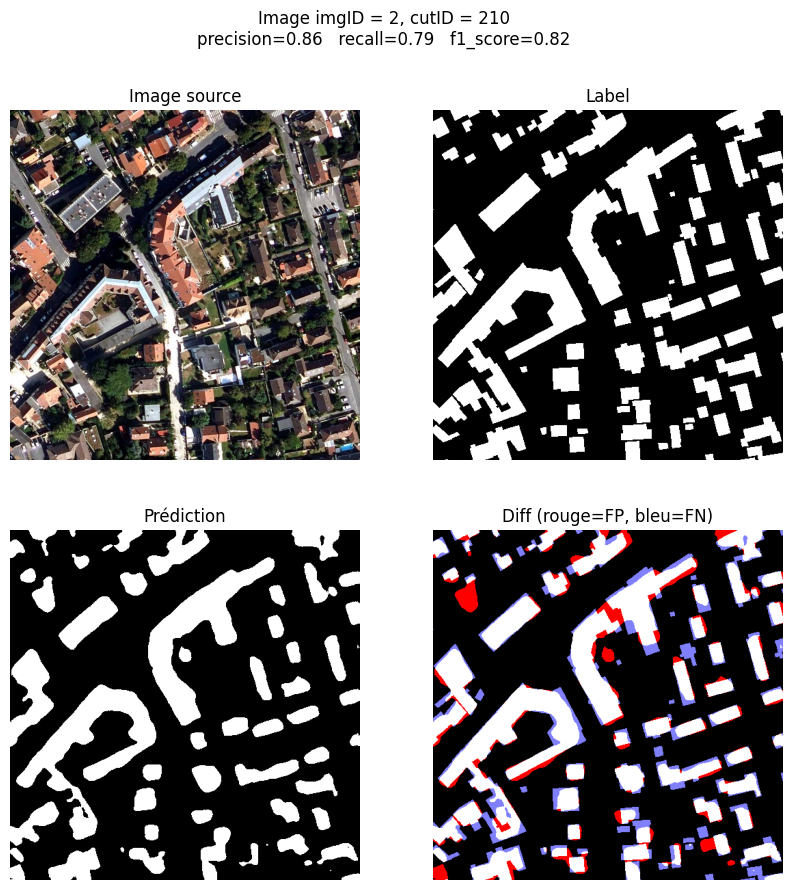

In [342]:
# Exemple d'image

imgID, cutID = 2, 210
plotter.plot(cutID=cutID, imgID=imgID, model=model)

images/BDORTHO_RGB/1000x1000/00-020.jpg
<class 'numpy.ndarray'>


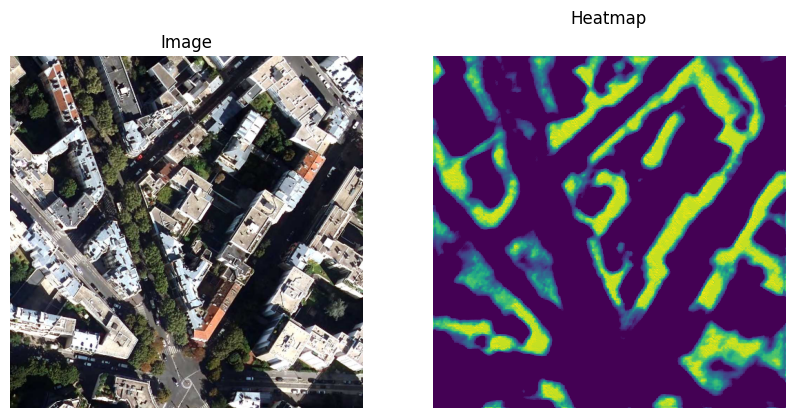

In [412]:
# Interprétation du modèle

# Image à analyser
#img_path = df_test['filename'].iloc[1]
img_path = df_test.loc[(df_test['imgID']== 0) & (df_test['cutID']== 20), 'filename'].values.item()
print (img_path)

# img_to_array() transforme l'image en batch
def img_to_array(img):
    array = np.expand_dims(img, axis=0)
    return array

# make_gradcam_heatmap crée la heatmap entre la dernière couche et la sortie
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # On crée le modèle qui mappe l'image d'entrée, la dernière sortie de convolution et la sortie
    grad_model = tf.keras.models.Model(
        inputs=model.inputs, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    # On calcule le gradient de la valeur prédite par rapport aux activations de la dernière couche
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vecteur des intensités du gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplication de chaque canal par son importance vis-à-vis de la sortie
    # puis addition pout obtenir la heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalisation pour la visualisation
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img = cv2.imread(img_path)
img = cv2.resize(img, IMAGE_SIZE)

# On enlève la fonction d'activation de la dernière couche
model.layers[-1].activation = None

# Génération de la heatmap
img_array = img_to_array(preprocess_image(img))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv2d_34")

fig = plt.figure(figsize=(10, 10))

# Affichage de l'image d'origine
ax1 = fig.add_subplot(121)
print (type(img))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax1.imshow(img)
plt.title('Image')
plt.axis('off')
# Affichage de la heatmap

ax2 = fig.add_subplot(122)
ax2.matshow(heatmap)
plt.title('Heatmap')
plt.axis('off')
plt.show();